# Too weak of a Santa's Sleigh 
### (Hands-on tutorial of the 'Elevate Your Problem-Solving Skills with Dynamic Programming' at UCLouvain/INGI -- 2023)

Santa's elves are packing gifts into Santa's sleigh. However, this year, the sleigh has faced some technical problem and the Elf-in-Chief had to take the decision to send it under technical revision. And in the meantime, the elves have to make do with a replacement sleigh. This one, however, has a weight limit, and not all gifts can be taken in one trip. The elves need to figure out which combination of gifts will maximize the total joy they bring while staying under the weight limit of the sleigh.

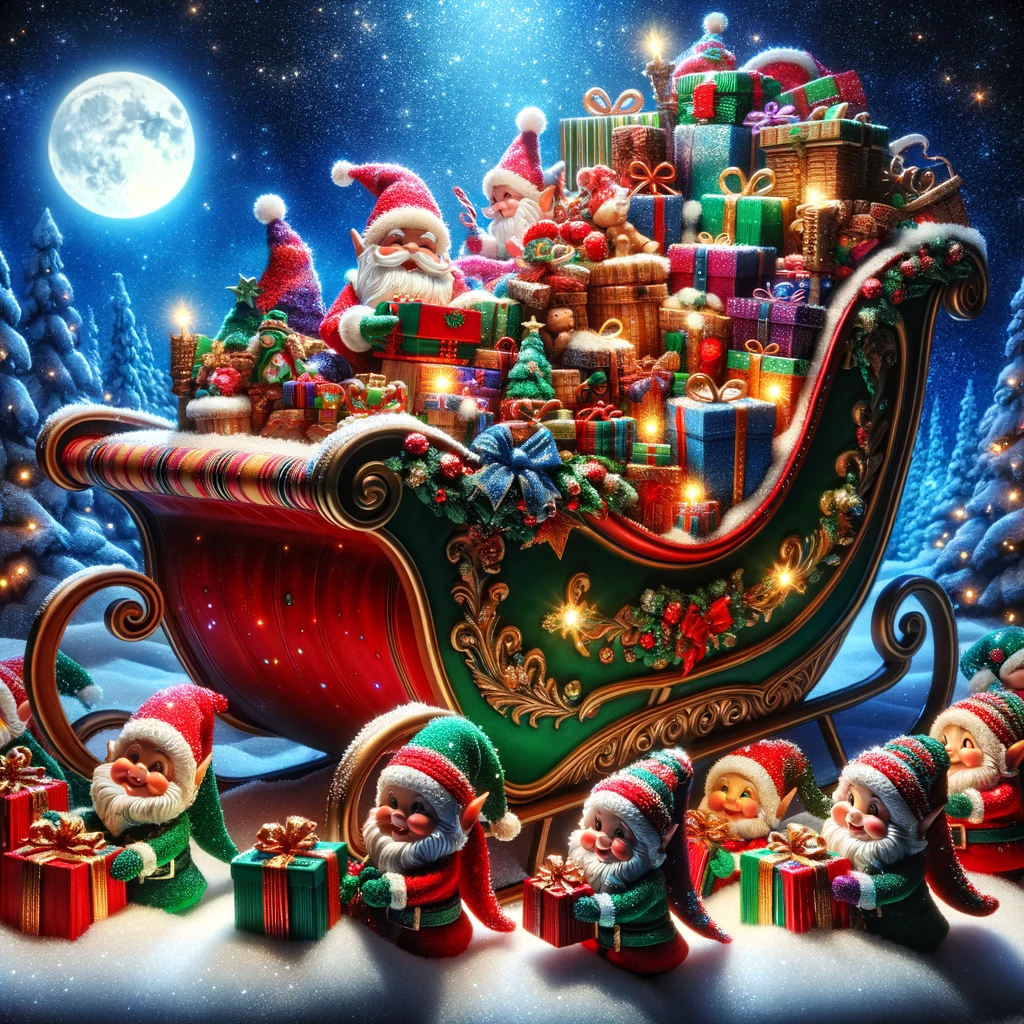

## Task

You are given a list of gifts, each with a weight and a joy value. Your task is to determine the combination of gifts that maximizes the total joy without exceeding the weight limit of the sleigh.

### Input Format: 

- The first line contains two integers N and W, where N is the number of gifts, and W is the weight limit of the sleigh.
- The next N lines each contain two integers, representing the weight and joy value of each gift.

### Example:

```
 5  50
10  60
20 100
30 120
40 140
50 160
```

### Output Format

Return the maximum total joy that can be carried in the sleigh without exceeding the weight limit.

### Example

Given the above input, your program should output the maximum joy that can be achieved without exceeding the weight limit of 50. In this case, your program should output 220.

### Notes

- This is a classic knapsack problem where you need to maximize the total joy while keeping the total weight under or equal to W.
- You can assume that all numbers are positive integers.
- You can choose to include or exclude any gift, but you cannot break a gift into smaller parts.

## Preliminary 

Before we get started with writing actual code, let us first start with the installation of the [`ddo`](https://github.com/xgillard/ddo) library (in Rust, we call these _crates_) which is the state-of-the-art library for writing BaB DD-based optimisation solvers.

In [55]:
:dep ddo           = "1.2.0"
:dep ordered-float = "3.6.0"

With the dependencies installed, we can now import the datatypes from `ddo` and an additional utilities (not essential for our purpose)

In [56]:
use ddo::*;
use ordered_float::OrderedFloat;
use std::{sync::Arc, time::{Duration, Instant}};

## The model 
The very first step when solving a problem is to start with the definition of the problem and its associated state. Let us start with the state.

In [57]:
/// In our DP model, we consider a state that simply consists of the remaining 
/// capacity in the knapsack. Additionally, we also consider the *depth* (number
/// of assigned variables) as part of the state since it useful when it comes to
/// determine the next variable to branch on.
#[derive(Debug, Clone, Copy, PartialEq, Eq, Hash)]
pub struct KnapsackState {
    /// the number of variables that have already been decided upon in the complete
    /// problem.
    depth: usize,
    /// the remaining capacity in the knapsack. That is the maximum load the sack
    /// can bear without cracking **given what is already in the sack**.
    capacity: usize
}

And to model the problem data (for the sake of convenience, we've added an extra constructor to create Knapsack instances)

In [58]:
/// This structure represents a particular instance of the knapsack problem.
/// This is the structure that will implement the knapsack model.
/// 
/// The problem definition is quite easy to understand: there is a knapsack having 
/// a maximum (weight) capacity, and a set of items to chose from. Each of these
/// items having a weight and a profit, the goal is to select the best subset of
/// the items to place them in the sack so as to maximize the profit.
pub struct Knapsack {
    /// The maximum capacity of the sack (when empty)
    capacity: usize,
    /// the profit of each item
    profit: Vec<isize>,
    /// the weight of each item.
    weight: Vec<usize>,
    /// the order in which the items are considered
    order: Vec<usize>,
}

impl Knapsack {
    pub fn new(capacity: usize, profit: Vec<isize>, weight: Vec<usize>) -> Self {
        let mut order = (0..profit.len()).collect::<Vec<usize>>();
        order.sort_unstable_by_key(|i| OrderedFloat(- profit[*i] as f64 / weight[*i] as f64));

        Knapsack { capacity, profit, weight, order }
    }
}

Now that the structure of the problem is clear, we can proceed to implementing the `Problem` trait of `ddo`. This is how the essentials of the model as specified. If you rememeber the theoretical lecture, a model should specify: 

- the decision variables it works on, along with their domains
- the state spaces it works on (this is the purpose of the `KnapsackState` type that has been defined before)
- among all these states, the initial state of the problem
- the initial value of the objective function
- the transition function (to move from one state to the next one after a decision is made)
- the transition cost function (to assess the impact of a decision on the objective we want to maximize)

In addition to all of the above, our model also specifies the next variable to branch on. This is not mandatory and it is a heuristic choice.

In [59]:
/// For each variable in the decision problem, there are two possible choices:
/// either we take the item in the sack, or we decide to leave it out. This
/// constant is used to indicate that the item is to be taken in the sack.
const TAKE_IT: isize = 1;
/// For each variable in the decision problem, there are two possible choices:
/// either we take the item in the sack, or we decide to leave it out. This
/// constant is used to indicate that the item is to be left out of the sack.
const LEAVE_IT_OUT: isize = 0;

/// This is how you implement the labeled transition system (LTS) semantics of
/// a simple dynamic program solving the knapsack problem. The definition of
/// each of the methods should be pretty clear and easy to grasp. Should you
/// want more details on the role of each of these methods, then you are 
/// encouraged to go checking the documentation of the `Problem` trait.
impl Problem for Knapsack {
    type State = KnapsackState;

    fn nb_variables(&self) -> usize {
        self.profit.len()
    }
    fn for_each_in_domain(&self, variable: Variable, state: &Self::State, f: &mut dyn DecisionCallback)
    {
        if state.capacity >= self.weight[variable.id()] {
            f.apply(Decision { variable, value: TAKE_IT });
        }
        f.apply(Decision { variable, value: LEAVE_IT_OUT });
    }
    fn initial_state(&self) -> Self::State {
        KnapsackState{ depth: 0, capacity: self.capacity }
    }
    fn initial_value(&self) -> isize {
        0
    }
    fn transition(&self, state: &Self::State, dec: Decision) -> Self::State {
        let mut ret = *state;
        ret.depth  += 1;
        if dec.value == TAKE_IT { 
            ret.capacity -= self.weight[dec.variable.id()] 
        }
        ret
    }
    fn transition_cost(&self, _state: &Self::State, dec: Decision) -> isize {
        self.profit[dec.variable.id()] * dec.value
    }

    fn next_variable(&self, depth: usize, _: &mut dyn Iterator<Item = &Self::State>) -> Option<Variable> {
        let n = self.nb_variables();
        if depth < n {
            Some(Variable(self.order[depth]))
        } else {
            None
        }
    }
}

## The relaxation

In addition to a dynamic programming (DP) model of the problem you want to solve, the branch and bound with MDD algorithm (and thus ddo) requires that you provide an additional relaxation allowing to control the maximum amount of space used by the decision diagrams that are compiled. That relaxation requires two operations: one to merge several nodes into one merged node that acts as an over approximation of the other nodes. The second operation is used to possibly offset some weight that would otherwise be lost to the arcs entering the newly created merged node.

In [60]:
/// First we define a structure to the relaxation.
pub struct KPRelax<'a>{pub pb: &'a Knapsack}

/// And then we implement the merge operator (merge many states into one) and the relaxation (relax the cost of arcs entering a merged state)
impl Relaxation for KPRelax<'_> {
    type State = KnapsackState;

    fn merge(&self, states: &mut dyn Iterator<Item = &Self::State>) -> Self::State {
        states.max_by_key(|node| node.capacity).copied().unwrap()
    }

    fn relax(&self, _source: &Self::State, _dest: &Self::State, _merged: &Self::State, _decision: Decision, cost: isize) -> isize {
        cost
    }
}

The last bit of information which we need to provide when implementing a ddo-based
solver is a `StateRanking`. This is an heuristic which is used to select the most
and least promising nodes as a means to only delete/merge the *least* promising nodes
when compiling restricted and relaxed DDs.

In [61]:
pub struct KPRanking;
impl StateRanking for KPRanking {
    type State = KnapsackState;

    fn compare(&self, a: &Self::State, b: &Self::State) -> std::cmp::Ordering {
        a.capacity.cmp(&b.capacity)
    }
}

## Putting the pieces together

In [63]:
/// This is your executable's entry point. It is the place where all the pieces are put together
/// to create a fast an effective solver for the knapsack problem.
fn main() {
    // These are the parameters of our example problem instance
    let capacity  = 50;
    let weights   = vec![10,  20,  30,  40,  50];
    let profits   = vec![60, 100, 120, 140, 160];

    // We now move on to creating an instance of the problem and relaxtation based on the above parameters
    let problem    = Knapsack::new(capacity, profits, weights);
    let relaxation = KPRelax{pb: &problem};
    let heuristic  = KPRanking;

    // To constrain the memory usage of our solver, let us now enforce a maximum width of 2 for each layer
    let width      = FixedWidth(2);
    // We want to make sure our solver never runs for ever, so we give it a maximum time budget of 15 seconds.
    // an alternative would have been to set `let cutoff = NoCutoff;` in which case the solver would not have
    // had any limit on the max time it can take to try and solve an instance.
    let cutoff     = TimeBudget::new(Duration::from_secs(15));
    // This is the fringe of the solver (the 'list' where all open subproblems are kept for later exploration).
    // DDO implements some alternative fringes which you might want to consider playing with, for instance the
    // `NoDupFringe` which was often shown to yield excellent performance boosts (it does however make some 
    // stronger assumptions than the `SimpleFringe`).
    let mut fringe = SimpleFringe::new(MaxUB::new(&heuristic));

    // Please consider this line as magic shenanigans for the time being. You will learn more about 
    // dominance checking later in this tutorial.
    let dominance  = EmptyDominanceChecker::default();

    // Create your solver object
    let mut solver = DefaultBarrierSolver::new(
        &problem, 
        &relaxation, 
        &heuristic, 
        &width, 
        &dominance,
        &cutoff, 
        &mut fringe,
    );

    // ... and then invoke it to actually solve the problem instance.
    let start = Instant::now();
    let Completion{ is_exact, best_value } = solver.maximize();

    // You can now collect all kinds of information about the optimal solution to your problem
    let duration = start.elapsed();
    let upper_bound = solver.best_upper_bound();
    let lower_bound = solver.best_lower_bound();
    let gap = solver.gap();
    let best_solution  = solver.best_solution().map(|mut decisions|{
        decisions.sort_unstable_by_key(|d| d.variable.id());
        decisions.iter().map(|d| d.value).collect::<Vec<_>>()
    });

    println!("Duration:   {:.3} seconds", duration.as_secs_f32());
    println!("Objective:  {}",            best_value.unwrap_or(-1));
    println!("Upper Bnd:  {}",            upper_bound);
    println!("Lower Bnd:  {}",            lower_bound);
    println!("Gap:        {:.3}",         gap);
    println!("Aborted:    {}",            !is_exact);
    println!("Solution:   {:?}",          best_solution.unwrap_or_default());
}

Congratulate yourself, you can now run your solver

In [64]:
main();

Duration:   0.002 seconds
Objective:  220
Upper Bnd:  220
Lower Bnd:  220
Gap:        0.000
Aborted:    false
Solution:   [0, 1, 1, 0, 0]


## Improving on the basics (Rough Upper Bound Pruning)

In addition to the `merge` and `relax` operations, the relaxation may also implement a `fast_upper_bound` method. Which one provides a useful bound to prune some portions of the state-space as the decision diagrams are compiled. (aka rough upper bound pruning). The bound computed with this method allows to incorporate some problem-specific knowledge to the resolution of the problem while keeping the framework perfectly generic.  It is important to note however that this bounding procedure will be run for each and every node of the compiled decision diagrams. It must therefore provide a very cheap to compute upper bound on the optimal objective value for the problem rooted in a given subproblem

In [65]:
/// First we define a structure to the relaxation.
pub struct KPRelax<'a>{pub pb: &'a Knapsack}

/// And then we implement the merge operator (merge many states into one) and the relaxation (relax the cost of arcs entering a merged state)
impl Relaxation for KPRelax<'_> {
    type State = KnapsackState;

    fn merge(&self, states: &mut dyn Iterator<Item = &Self::State>) -> Self::State {
        states.max_by_key(|node| node.capacity).copied().unwrap()
    }

    fn relax(&self, _source: &Self::State, _dest: &Self::State, _merged: &Self::State, _decision: Decision, cost: isize) -> isize {
        cost
    }

    fn fast_upper_bound(&self, state: &Self::State) -> isize {
        let mut depth = state.depth;
        let mut max_profit = 0;
        let mut capacity = state.capacity;

        while capacity > 0 && depth < self.pb.profit.len() {
            let item = self.pb.order[depth];

            if capacity >= self.pb.weight[item] {
                max_profit += self.pb.profit[item];
                capacity -= self.pb.weight[item];
            } else {
                let item_ratio = capacity as f64 / self.pb.weight[item] as f64;
                let item_profit = item_ratio * self.pb.profit[item] as f64;
                max_profit += item_profit.floor() as isize;
                capacity = 0;
            }

            depth += 1;
        }

        max_profit
    }
}

(Note: the example problem instance is so small that you will likely not notice any difference in the run time to solve the example)

In [66]:
main();

Duration:   0.002 seconds
Objective:  220
Upper Bnd:  220
Lower Bnd:  220
Gap:        0.000
Aborted:    false
Solution:   [0, 1, 1, 0, 0]


## Going Slightly More Advanced (Automatic Dominance Checking)

When solving a Knapsack problem (this is also true of extremely many other optimisation problems), we can define dominance relations between states obtained throughout the search. That is to say, we can define a relation between states of a same layer that allow us to tell that one state is *strictly better* than another node. As a consequence of which, we can be sure that exploring the first node suffices to find the optimal solution (the second node may safely be ignored).

In the case of the knapsack, we know that state *s1 is strictly better than s2* if *s1.capacity >= s2.capacity and s1 has a larger objective value than s2*.

In [67]:
pub struct KPDominance;
impl Dominance for KPDominance {
    type State = KnapsackState;
    type Key = usize;

    fn get_key(&self, state: Arc<Self::State>) -> Option<Self::Key> {
        Some(state.depth)
    }

    fn nb_dimensions(&self, _state: &Self::State) -> usize {
        1
    }

    fn get_coordinate(&self, state: &Self::State, _: usize) -> isize {
        state.capacity as isize
    }

    fn use_value(&self) -> bool {
        true
    }
}

The main function can thus be rewritten to account for the newly defined dominance relation (and hence further improve the efficiency of your solver).

In [68]:
/// This is your executable's entry point. It is the place where all the pieces are put together
/// to create a fast an effective solver for the knapsack problem.
fn main() {
    // These are the parameters of our example problem instance
    let capacity  = 50;
    let weights   = vec![10,  20,  30,  40,  50];
    let profits   = vec![60, 100, 120, 140, 160];

    // We now move on to creating an instance of the problem and relaxtation based on the above parameters
    let problem    = Knapsack::new(capacity, profits, weights);
    let relaxation = KPRelax{pb: &problem};
    let heuristic  = KPRanking;

    // To constrain the memory usage of our solver, let us now enforce a maximum width of 2 for each layer
    let width      = FixedWidth(2);
    // We want to make sure our solver never runs for ever, so we give it a maximum time budget of 15 seconds.
    // an alternative would have been to set `let cutoff = NoCutoff;` in which case the solver would not have
    // had any limit on the max time it can take to try and solve an instance.
    let cutoff     = TimeBudget::new(Duration::from_secs(15));
    // This is the fringe of the solver (the 'list' where all open subproblems are kept for later exploration).
    // DDO implements some alternative fringes which you might want to consider playing with, for instance the
    // `NoDupFringe` which was often shown to yield excellent performance boosts (it does however make some 
    // stronger assumptions than the `SimpleFringe`).
    let mut fringe = SimpleFringe::new(MaxUB::new(&heuristic));

    // And then we instanciate the dominance relationship (this is a bit more advanced)
    let dominance  = SimpleDominanceChecker::new(KPDominance);

    // Create your solver object
    let mut solver = DefaultBarrierSolver::new(
        &problem, 
        &relaxation, 
        &heuristic, 
        &width, 
        &dominance,
        &cutoff, 
        &mut fringe,
    );
    
    // ... and then invoke it to actually solve the problem instance.
    let start = Instant::now();
    let Completion{ is_exact, best_value } = solver.maximize();
    
    // You can now collect all kinds of information about the optimal solution to your problem
    let duration = start.elapsed();
    let upper_bound = solver.best_upper_bound();
    let lower_bound = solver.best_lower_bound();
    let gap = solver.gap();
    let best_solution  = solver.best_solution().map(|mut decisions|{
        decisions.sort_unstable_by_key(|d| d.variable.id());
        decisions.iter().map(|d| d.value).collect::<Vec<_>>()
    });

    println!("Duration:   {:.3} seconds", duration.as_secs_f32());
    println!("Objective:  {}",            best_value.unwrap_or(-1));
    println!("Upper Bnd:  {}",            upper_bound);
    println!("Lower Bnd:  {}",            lower_bound);
    println!("Gap:        {:.3}",         gap);
    println!("Aborted:    {}",            !is_exact);
    println!("Solution:   {:?}",          best_solution.unwrap_or_default());
}

In [69]:
main();

Duration:   0.004 seconds
Objective:  220
Upper Bnd:  220
Lower Bnd:  220
Gap:        0.000
Aborted:    false
Solution:   [0, 1, 1, 0, 0]


# Thank you for attending our seminar

Should you want to cite ddo in one of your publications: 
```
@misc{gillard:20:ddo,
    author       = {Xavier Gillard, Pierre Schaus, Vianney Coppé},
    title        = {Ddo, a generic and efficient framework for MDD-based optimization},
    howpublished = {IJCAI-20},
    year         = {2020},
    note         = {Available from \url{https://github.com/xgillard/ddo}},
}
```